In [20]:
import os
from dotenv import load_dotenv
load_dotenv()
import tweepy
twitter_client = tweepy.Client(bearer_token=os.getenv("TWITTER_BEARER_TOKEN"))
from google import genai
AI_client = genai.Client(api_key = os.getenv("GEMINI_API_KEY"))
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [ ]:
# Testing Twitter API
# response = twitter_client.search_recent_tweets(query='AI')
# print(type(response))
# print(response)

<class 'tweepy.client.Response'>
Response(data=[<Tweet id=1914293051364622445 text='j’ai pas peur de ta menace CONNASSE tu nous insultes de clochards depuis vrm tu devrais pas parler https://t.co/LmLRaBsJAW'>, <Tweet id=1914293050873880647 text='RT @cyphenty: aí na minha vez de ser jovem adulta todo mundo é insuportável e crente'>, <Tweet id=1914293050509234221 text='partner*AIコトリと相談して徐々にYouTubeチャンネルを変えます。まずは王道アニソンを目指したこの曲から。\nhttps://t.co/noZeDSWhU2 https://t.co/RdQ8I6SJtp'>, <Tweet id=1914293050496741596 text='RT @Didotxyz_: 🚀 DI Mainnet &amp; DI-A are officially LIVE! \n\nIt’s time to enter a new era of Web3 AI.\nLog in with X → Claim your rewards → Sta…'>, <Tweet id=1914293050257399870 text='Ai, kāda nelaime.'>, <Tweet id=1914293050030907434 text='@elonmusk Grok needs more info given to it. I can actually feel its want to help this Country. All AI agree with me on what this country should do and very fast. Future for everyone is questionable. Not many live to 100 years old.'>, <Twe

In [9]:
# Consume a Twitter API

response = twitter_client.search_recent_tweets(
    query='AI',
    tweet_fields=["created_at", "author_id", "lang", "possibly_sensitive"],
    max_results=90
)

In [ ]:
# Segregating the response data into a DataFrame

tweet_data = []
for tweet in response.data:
    tweet_data.append({
        "id": tweet.id,
        "text": tweet.text,
        "created_at": tweet.created_at,
        "author_id": tweet.author_id,
        "lang": tweet.lang,
        "possibly_sensitive": tweet.possibly_sensitive
    })

df = pd.DataFrame(tweet_data)
df.drop_duplicates(subset='id', inplace=True)
print(df.head())

                    id                                               text  \
0  1914296893443813599  Tend to agree, AI and medical industry will be...   
1  1914296893389299716        @sporsho_AI @grok @AskPerplexity Fact check   
2  1914296893309411420  Doidera né, dormindo, sonhando meu consciente ...   
3  1914296893250871472  RT @AI_Sol_Trade: 🚀 From tools to intelligence...   
4  1914296892378251690  3/ The Impact\n\nWith over 7 million users, Cl...   

                 created_at            author_id lang  possibly_sensitive  
0 2025-04-21 12:35:19+00:00  1352329967451815936   en               False  
1 2025-04-21 12:35:19+00:00            137750877   en               False  
2 2025-04-21 12:35:19+00:00           2897845775   pt               False  
3 2025-04-21 12:35:19+00:00  1890975924478439425   en               False  
4 2025-04-21 12:35:19+00:00  1793956417717555200   en               False  


In [ ]:
# Dumping the segregated data into SQL (Using SQLite for simplicity)
engine = create_engine('sqlite:///tweets_data.db')
df.to_sql('twitter_data', con=engine, if_exists='replace', index=False)

90

In [ ]:
# Reading the data back from SQLite file
engine = create_engine('sqlite:///tweets_data.db')
df_read = pd.read_sql('SELECT * FROM twitter_data', con=engine)
print(df_read.head())

                    id                                               text  \
0  1914296893443813599  Tend to agree, AI and medical industry will be...   
1  1914296893389299716        @sporsho_AI @grok @AskPerplexity Fact check   
2  1914296893309411420  Doidera né, dormindo, sonhando meu consciente ...   
3  1914296893250871472  RT @AI_Sol_Trade: 🚀 From tools to intelligence...   
4  1914296892378251690  3/ The Impact\n\nWith over 7 million users, Cl...   

                   created_at            author_id lang  possibly_sensitive  
0  2025-04-21 12:35:19.000000  1352329967451815936   en                   0  
1  2025-04-21 12:35:19.000000            137750877   en                   0  
2  2025-04-21 12:35:19.000000           2897845775   pt                   0  
3  2025-04-21 12:35:19.000000  1890975924478439425   en                   0  
4  2025-04-21 12:35:19.000000  1793956417717555200   en                   0  


<Axes: xlabel='Time (H:M:S)', ylabel='Tweet Count'>

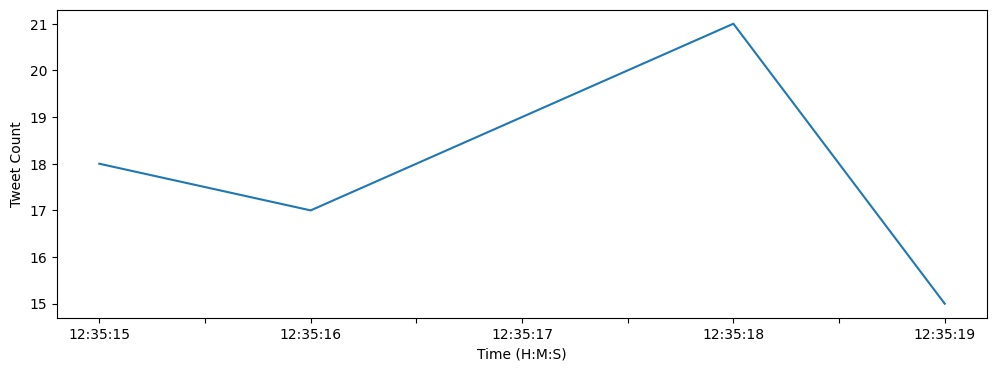

In [ ]:
# Analyze the data by time (precision to seconds)
df_read['created_at'] = pd.to_datetime(df_read['created_at'])
df_read['second'] = df_read['created_at'].dt.strftime('%H:%M:%S')
df_read['second'].value_counts().sort_index().plot(kind='line', figsize=(12, 4), xlabel='Time (H:M:S)', ylabel='Tweet Count')

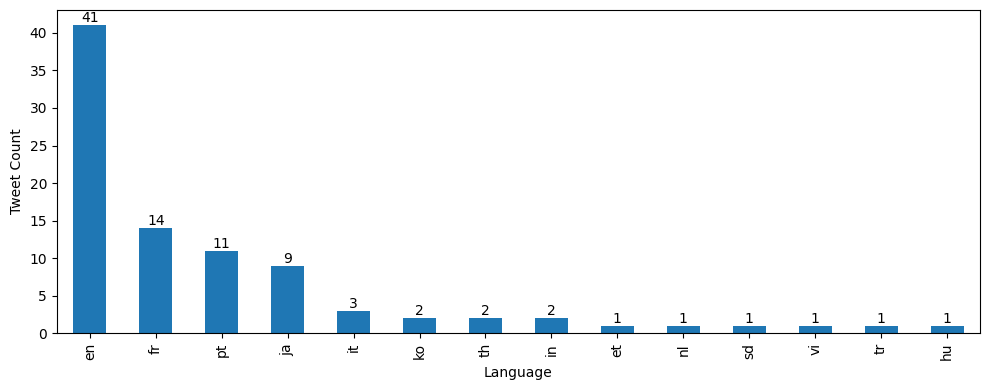

In [21]:
# Analyze the data by language
ax = df_read['lang'].value_counts().plot(kind='bar', figsize=(10, 4), xlabel='Language', ylabel='Tweet Count')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()


In [22]:
# Analyze the data for sensitive content
counts = df_read['possibly_sensitive'].dropna().value_counts().sort_index()
print(f"Sensitive       : {counts.get(1, 0)}")
print(f"Not Sensitive   : {counts.get(0, 0)}")


Sensitive       : 4
Not Sensitive   : 86


In [31]:
# Integrate LLM for interactive responses

def question_llm(user_question, df = df_read):
    data_summary = {}
    df['second'] = df['created_at'].dt.strftime('%H:%M:%S')
    data_summary['tweets_per_second'] = df['second'].value_counts().sort_index().to_dict()
    data_summary['tweets_by_language'] = df['lang'].value_counts().to_dict()
    counts = df['possibly_sensitive'].dropna().value_counts().sort_index()
    data_summary['sensitive_tweets'] = {'Sensitive': int(counts.get(1, 0)),'Not Sensitive': int(counts.get(0, 0))}
    
    prompt = f"""
            User will ask questions about Twitter data. Here is a summary of the dataset:
            Tweets Per Second: {data_summary['tweets_per_second']}
            Tweets By Language: {data_summary['tweets_by_language']}
            Possibly Sensitive Tweets: {data_summary['sensitive_tweets']}

            Answer this user's question: {user_question}
            """

    response = AI_client.models.generate_content(model="gemini-2.0-flash", contents = prompt)
    return response.text


In [34]:
question_llm("What time has the highest number of posted tweets?")

'The time with the highest number of posted tweets is 12:35:18, with 21 tweets.\n'

In [33]:
question_llm("What is the most common language used in the tweets? Tell the number of that.")

'The most common language used in the tweets is English (en), with 41 tweets.\n'

In [ ]:
question_llm("What is the least common language used in the tweets? Tell the name from codes and number of them.")

'The least common languages used in the tweets (with only 1 tweet each) are: et (Estonian), nl (Dutch), sd (Sindhi), vi (Vietnamese), tr (Turkish), and hu (Hungarian).\n'

In [32]:
question_llm("Is there any sensitive tweet in the data? Tell me the number of non-sensitive tweets.")

'Yes, there are sensitive tweets in the data. There are 86 non-sensitive tweets.\n'